### Aims to predict final grading using regression from groups of students' performance based on Medu and Fedu (mother and father education) using linear regression, ridge regression, and random forest.

In [1]:
library(ggplot2) # Plotting visualization
library(tidyverse)
library(randomForest) # Random Forest
library(glmnet) # Ridge regression
library(data.table)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.1      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-6


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




 ### read the data from the csv files

In [2]:
Port_course <- read.csv("/kaggle/input/student-performance-data-set/student-por.csv", sep = ",", header = TRUE)
Math_course <- read.csv("/kaggle/input/math-students/student-mat.csv", sep = ",", header = TRUE)

### Combine the datasets

In [3]:
dataset <- rbind(Math_course, Port_course)

### Select relevant columns Medu Fedu and G3 as we are going to analyse data based on these three columns

In [4]:
selected_cols <- c("Fedu", "Medu", "G3")
data <- dataset[, selected_cols]

# Visualize the initial data

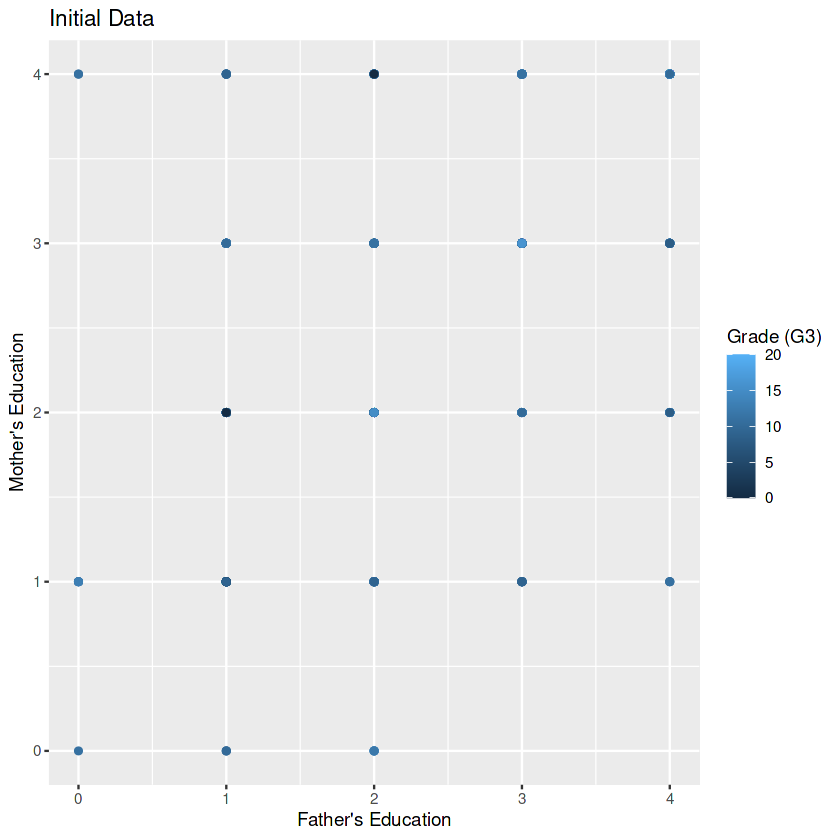

In [5]:
ggplot(data = data, aes(x = Fedu, y = Medu, color = G3)) +
  geom_point() +
  labs(x = "Father's Education", y = "Mother's Education", color = "Grade (G3)") +
  ggtitle("Initial Data")

# Factorize the variables

In [6]:
for (col in c("Fedu", "Medu")) {
  data[[col]] <- as.factor(data[[col]])
}

# Visualize the transformed data

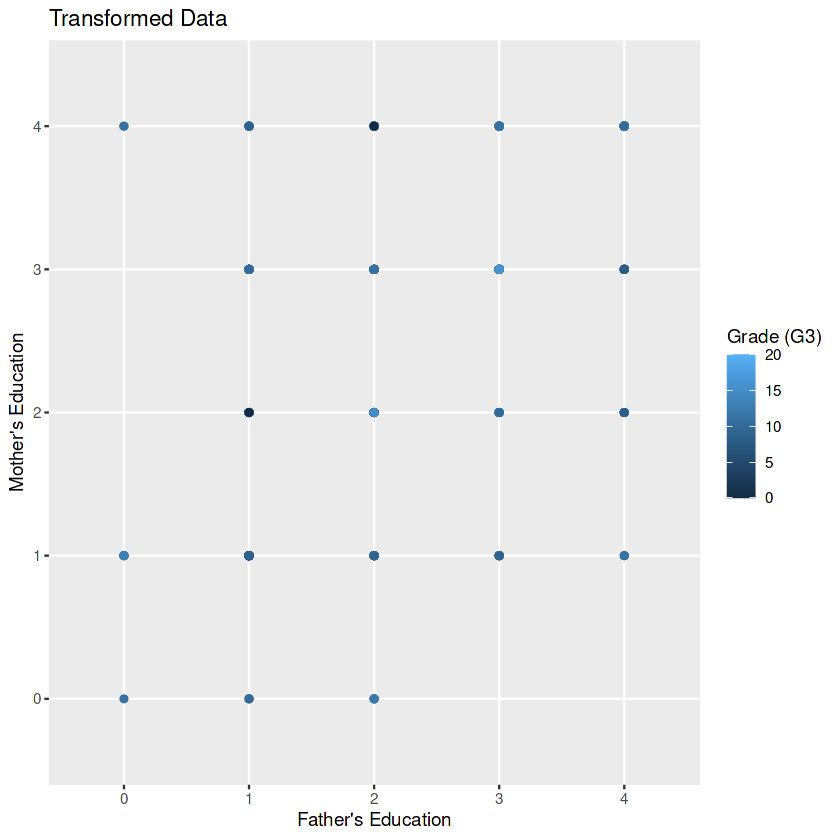

In [7]:
ggplot(data = data, aes(x = Fedu, y = Medu, color = G3)) +
  geom_point() +
  labs(x = "Father's Education", y = "Mother's Education", color = "Grade (G3)") +
  ggtitle("Transformed Data")

# Split the data into train and test sets

In [8]:
set.seed(2022)
train_indices <- sample(1:nrow(data), floor(0.7 * nrow(data)))
train_data <- data[train_indices, ]
test_data <- data[-train_indices, ]

# Linear regression

In [9]:

linear_model <- lm(G3 ~ ., data = train_data)

# Predict using linear regression
linear_pred <- predict(linear_model, newdata = test_data)

# Ridge regression

In [10]:

x_train <- model.matrix(G3 ~ ., train_data)[, -1]
x_test <- model.matrix(G3 ~ ., test_data)[, -1]

cv_ridge <- cv.glmnet(x_train, train_data$G3, alpha = 0)
ridge_model <- glmnet(x_train, train_data$G3, alpha = 0, lambda = cv_ridge$lambda.min)
ridge_pred <- predict(ridge_model, newx = x_test)

# Random Forest

In [11]:

rf_model <- randomForest(G3 ~ ., data = train_data)

# Predict using Random Forest
rf_pred <- predict(rf_model, newdata = test_data)

# Calculate RMSE

In [12]:
rmse_linear <- sqrt(mean((test_data$G3 - linear_pred)^2))
rmse_ridge <- sqrt(mean((test_data$G3 - ridge_pred)^2))
rmse_rf <- sqrt(mean((test_data$G3 - rf_pred)^2))

# Create a data frame for results

In [13]:

result <- data.frame(Model = c("Linear Regression", "Ridge Regression", "Random Forest"),
                     RMSE = c(rmse_linear, rmse_ridge, rmse_rf))

# Print the results
print(result)

              Model     RMSE
1 Linear Regression 3.867496
2  Ridge Regression 3.849018
3     Random Forest 3.850528


# Performance Metrics

In [14]:
linear_metrics <- data.frame(
  R_squared = summary(linear_model)$r.squared,
  Adj_R_squared = summary(linear_model)$adj.r.squared,
  MAE = mean(abs(test_data$G3 - linear_pred))
)

ridge_metrics <- data.frame(
  R_squared = cor(test_data$G3, ridge_pred)^2,
  Adj_R_squared = 1 - (1 - cor(test_data$G3, ridge_pred)^2) * ((length(test_data$G3) - 1)/(length(test_data$G3) - length(ridge_model$beta) - 1)),
  MAE = mean(abs(test_data$G3 - ridge_pred))
)

rf_metrics <- data.frame(
  R_squared = cor(test_data$G3, rf_pred)^2,
  Adj_R_squared = 1 - (1 - cor(test_data$G3, rf_pred)^2) * ((length(test_data$G3) - 1)/(length(test_data$G3) - rf_model$ntree - 1)),
  MAE = mean(abs(test_data$G3 - rf_pred))
)

#### Feature Importance Analysis - Random Forest
#### Linear Regression - Residual Analysis
#### Plotting Residuals vs. Fitted Values - Linear Regression

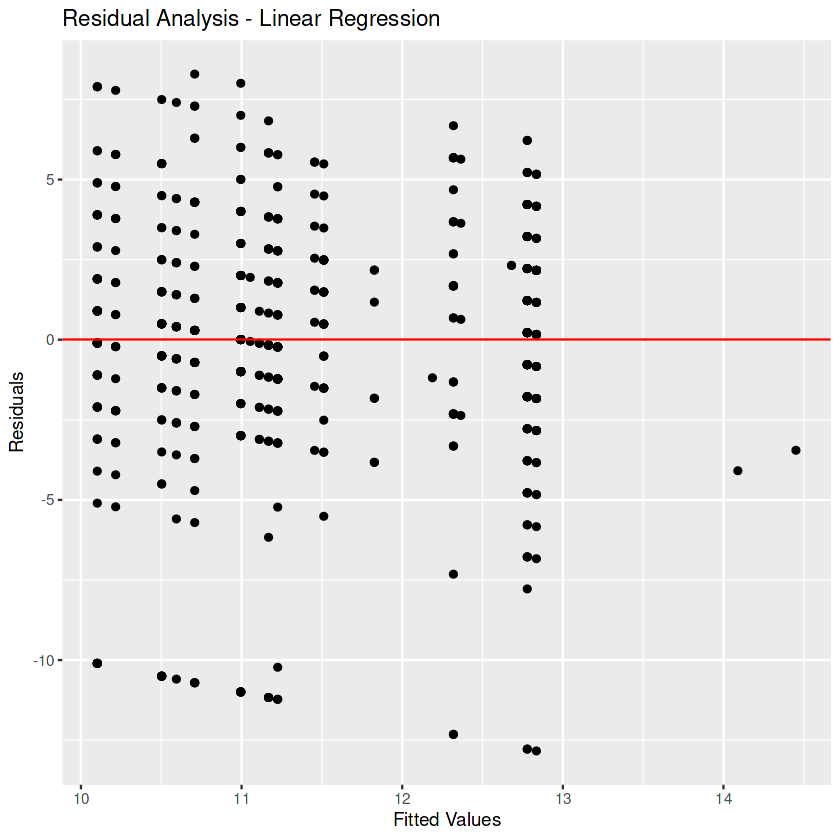

In [15]:

RF_importance <- data.frame(Feature = colnames(train_data)[-ncol(train_data)],
                            Importance = importance(rf_model)[order(importance(rf_model), decreasing = TRUE)])


linear_resid <- data.frame(Residuals = residuals(linear_model),
                           Fitted_Values = fitted(linear_model))


ggplot(linear_resid, aes(x = Fitted_Values, y = Residuals)) +
  geom_point() +
  geom_hline(yintercept = 0, color = "red") +
  xlab("Fitted Values") +
  ylab("Residuals") +
  ggtitle("Residual Analysis - Linear Regression")

## Distribution of Grades (G3)
### Box Plot of Grades by Parent Education
### Scatter Plot of Grades vs. Parent Education
### Bar Plot of Parent Education Levels

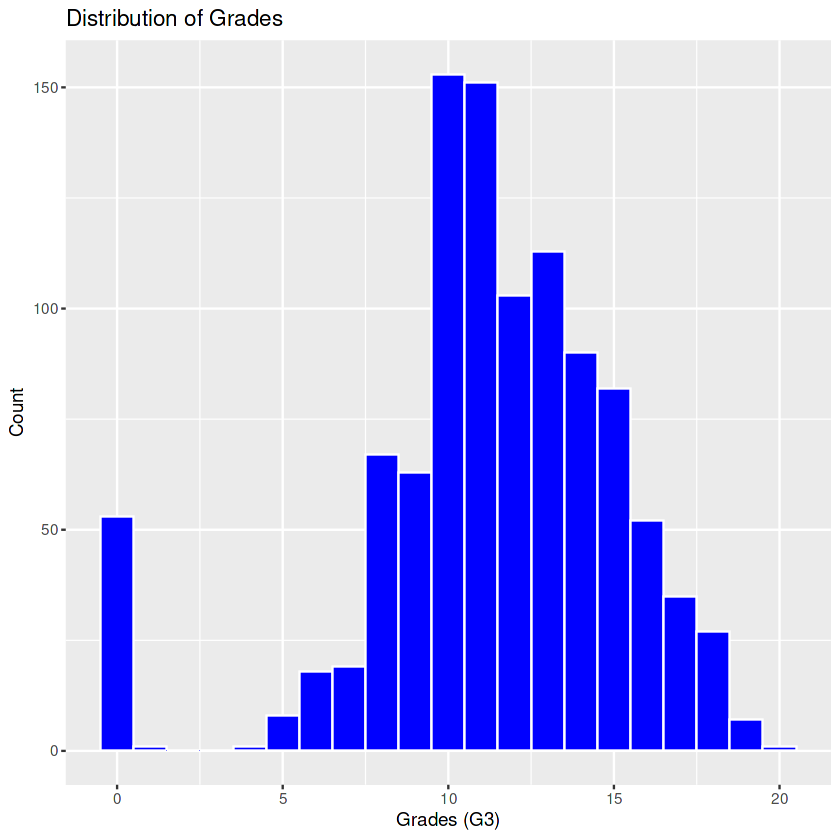

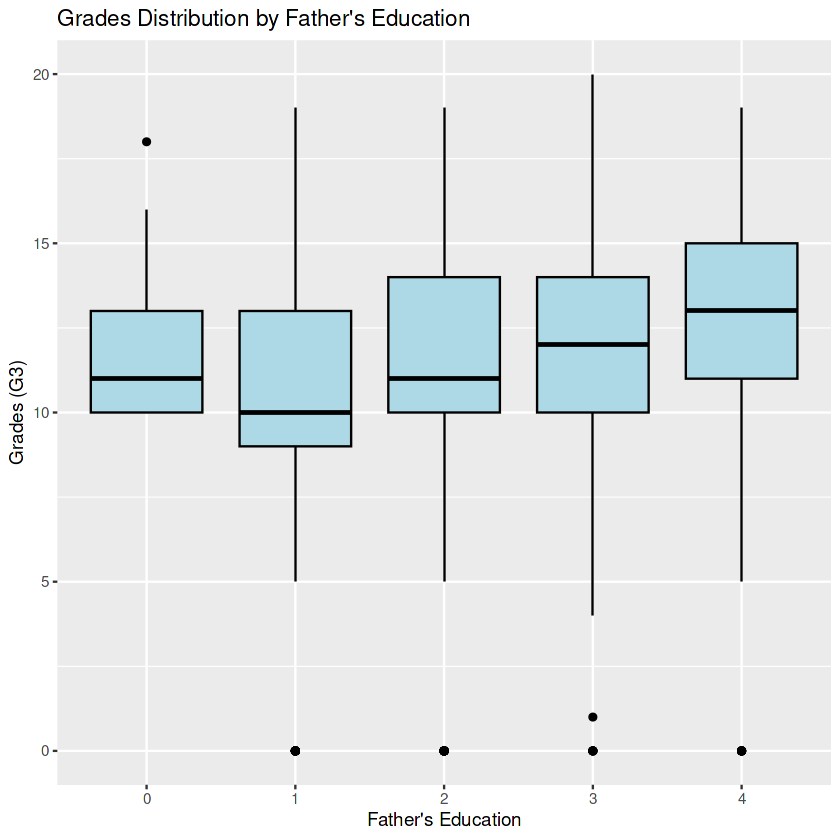

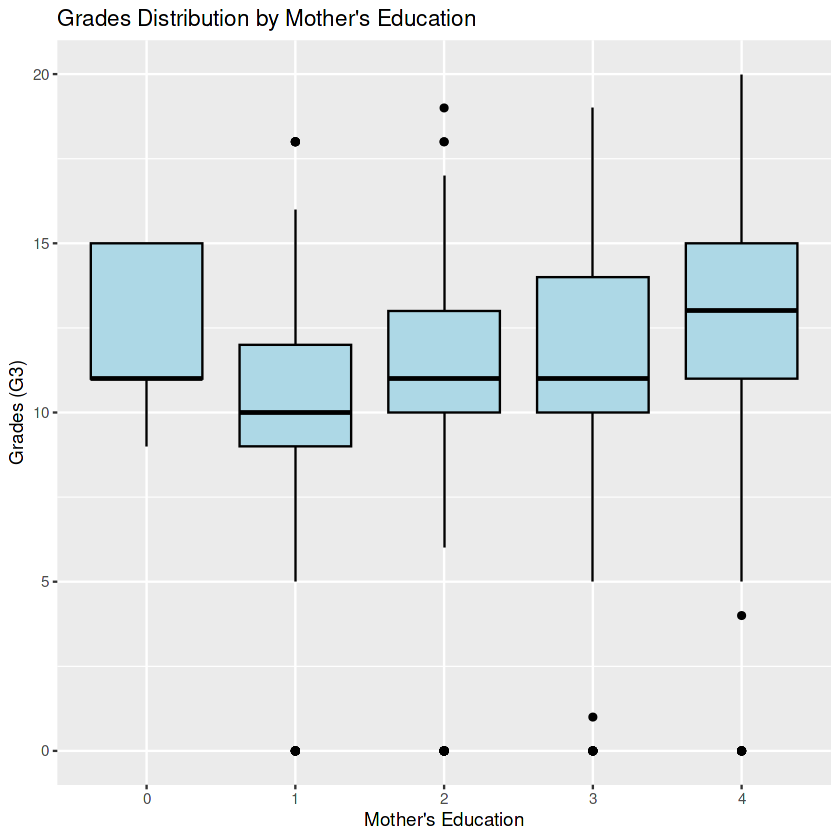

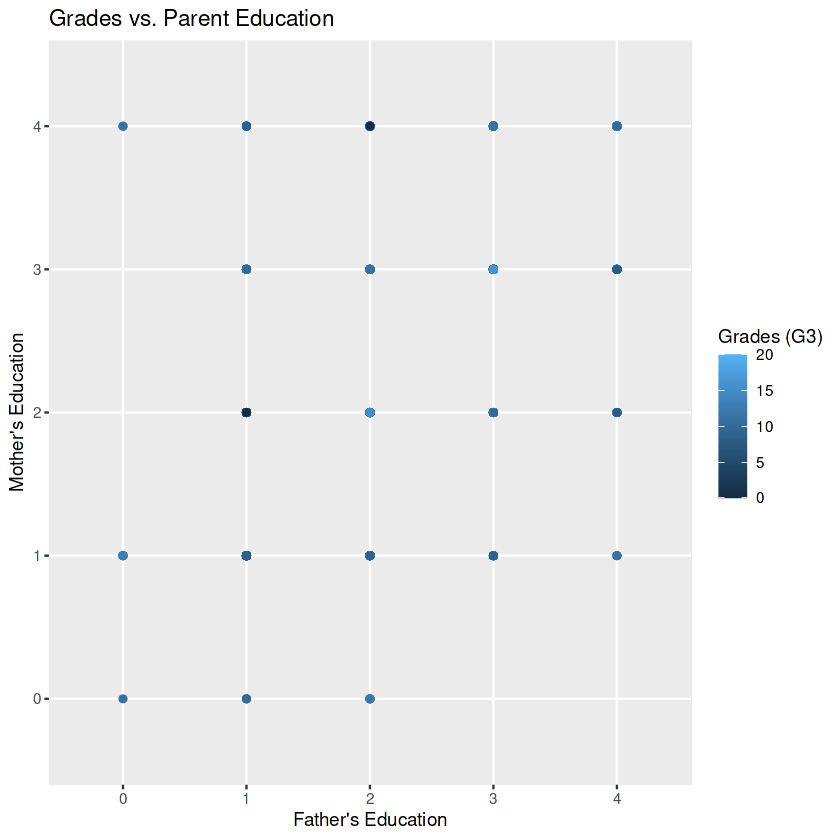

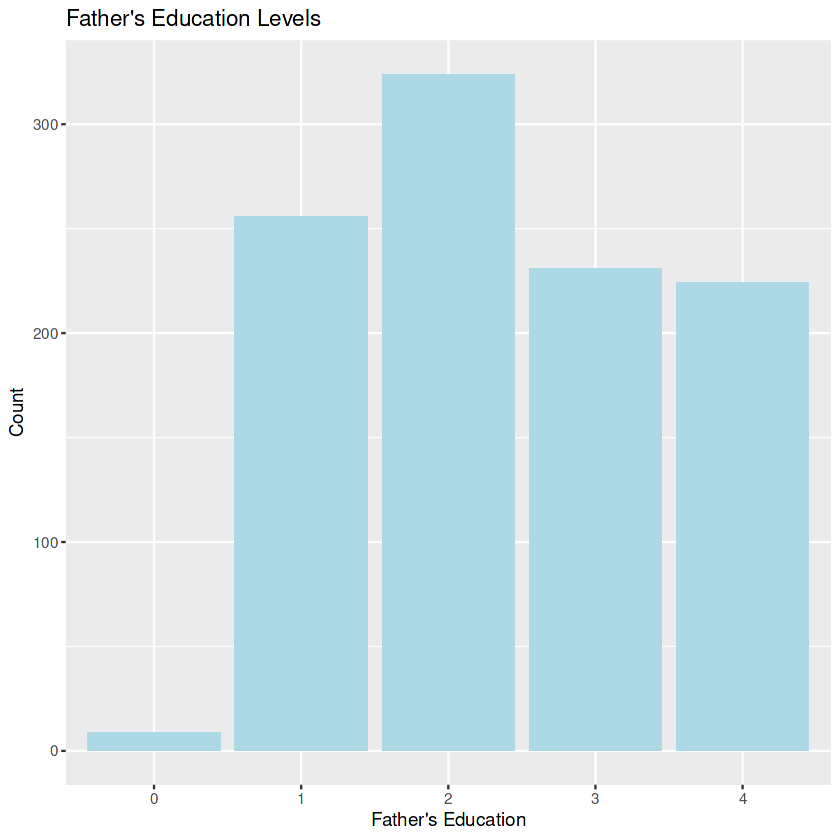

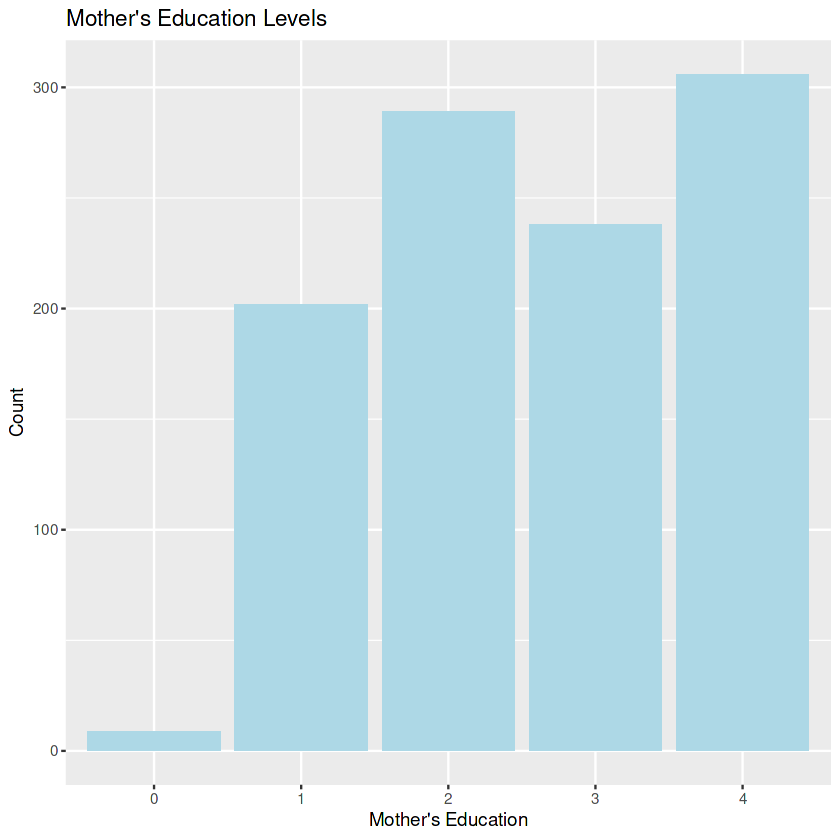

In [16]:

ggplot(data = data, aes(x = G3)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "white") +
  labs(x = "Grades (G3)", y = "Count") +
  ggtitle("Distribution of Grades")


ggplot(data = data, aes(x = factor(Fedu), y = G3)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(x = "Father's Education", y = "Grades (G3)") +
  ggtitle("Grades Distribution by Father's Education")

ggplot(data = data, aes(x = factor(Medu), y = G3)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(x = "Mother's Education", y = "Grades (G3)") +
  ggtitle("Grades Distribution by Mother's Education")


ggplot(data = data, aes(x = Fedu, y = Medu, color = G3)) +
  geom_point() +
  labs(x = "Father's Education", y = "Mother's Education", color = "Grades (G3)") +
  ggtitle("Grades vs. Parent Education")

ggplot(data = data, aes(x = factor(Fedu))) +
  geom_bar(fill = "lightblue") +
  labs(x = "Father's Education", y = "Count") +
  ggtitle("Father's Education Levels")

ggplot(data = data, aes(x = factor(Medu))) +
  geom_bar(fill = "lightblue") +
  labs(x = "Mother's Education", y = "Count") +
  ggtitle("Mother's Education Levels")

### Model Performance Comparison

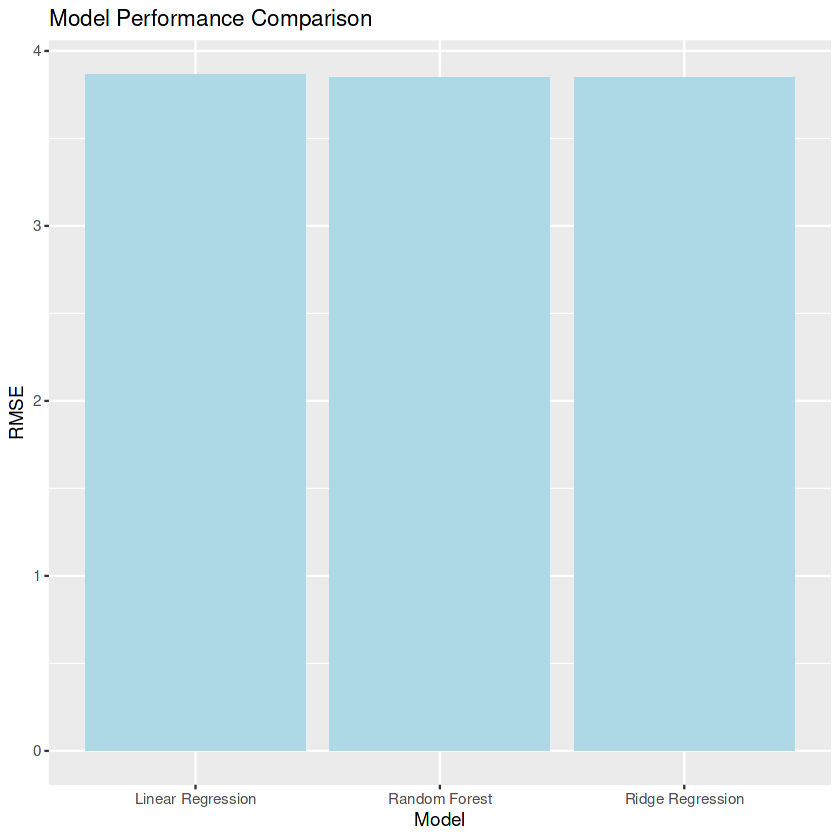

In [17]:
ggplot(data = result, aes(x = Model, y = RMSE)) +
  geom_bar(stat = "identity", fill = "lightblue") +
  labs(x = "Model", y = "RMSE") +
  ggtitle("Model Performance Comparison")

# Plot the results

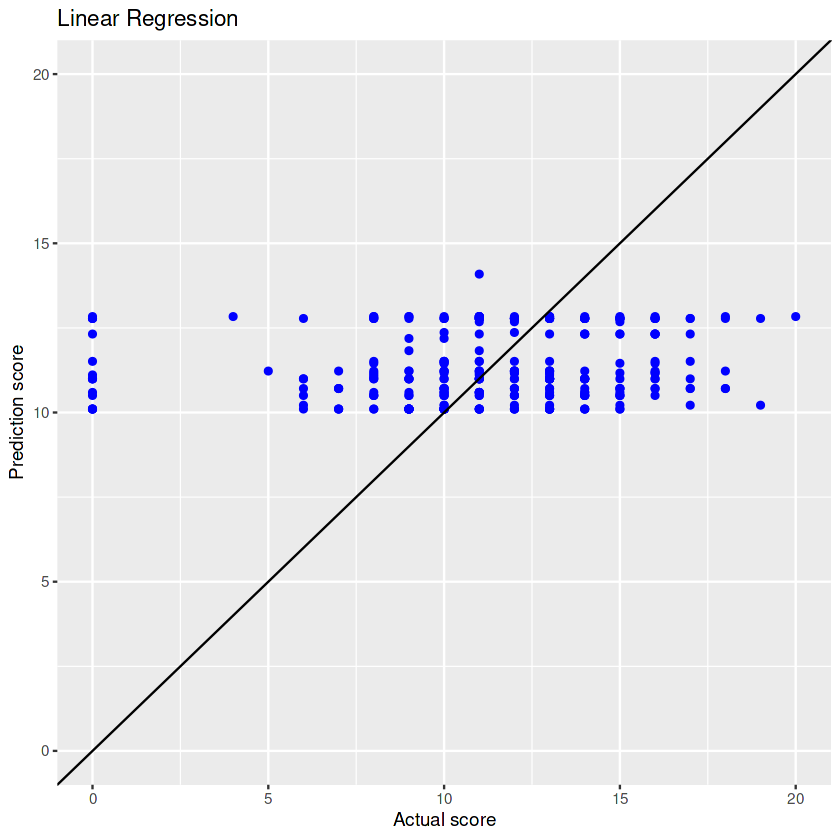

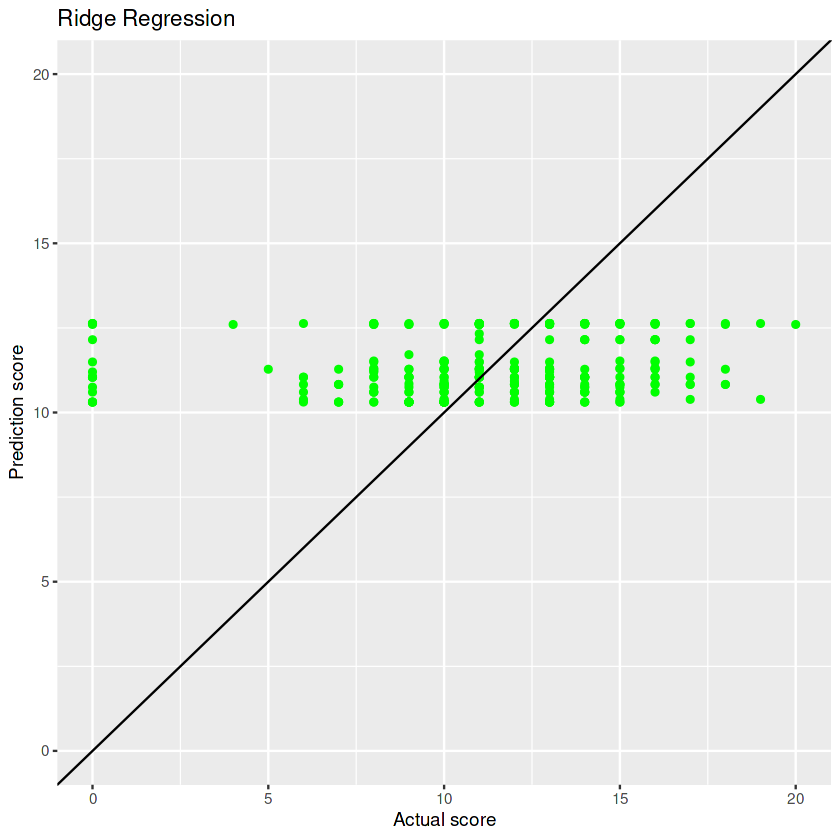

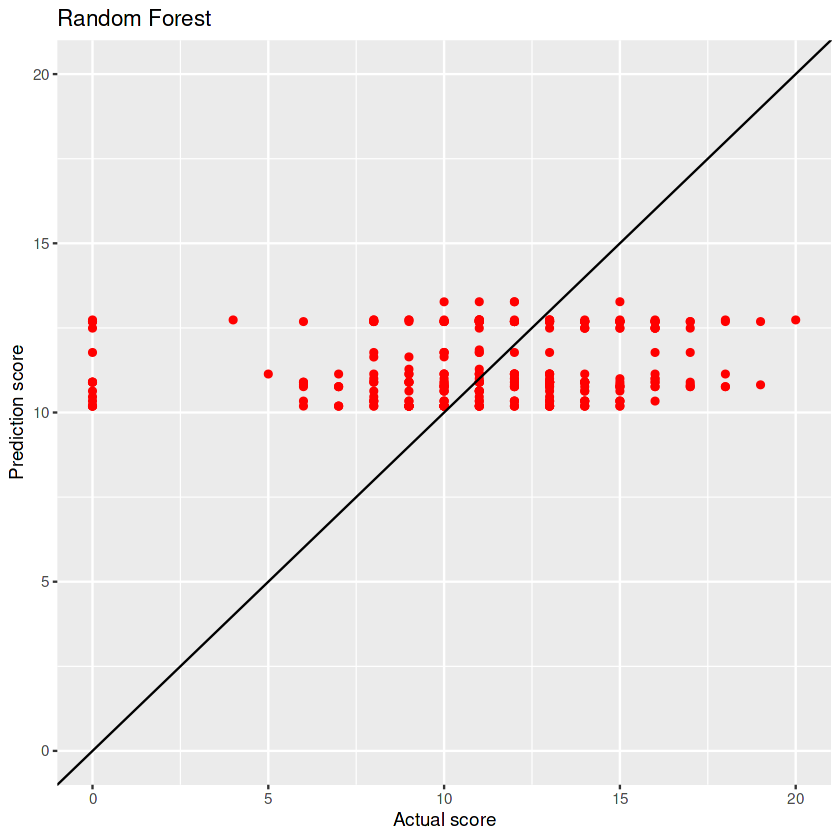

In [18]:
ggplot(data = test_data, aes(x = G3, y = linear_pred)) +
  geom_point(color = "blue") +
  geom_abline(colour = "black") +
  xlab("Actual score") +
  ylab("Prediction score") +
  xlim(0, 20) +
  ylim(0, 20) +
  ggtitle("Linear Regression")

ggplot(data = test_data, aes(x = G3, y = ridge_pred)) +
  geom_point(color = "green") +
  geom_abline(colour = "black") +
  xlab("Actual score") +
  ylab("Prediction score") +
  xlim(0, 20) +
  ylim(0, 20) +
  ggtitle("Ridge Regression")

ggplot(data = test_data, aes(x = G3, y = rf_pred)) +
  geom_point(color = "red") +
  geom_abline(colour = "black") +
  xlab("Actual score") +
  ylab("Prediction score") +
  xlim(0, 20) +
  ylim(0, 20) +
  ggtitle("Random Forest")